In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy import signal, constants
import math

# Define fitting functions
def expf(x, a, b, c):
    return a*np.exp(-b*x)+c
def linf(x, m, q):
    return m * x + q
def hpbf(rl, z0):
    return (rl+z0)/(rl-z0)
def cosf(t, k, Vpp, w):
    return k + Vpp/2*np.cos(w*t)
def sinf(t, k, Vpp, w):
    return k + Vpp/2*np.sin(w*t)
#def sinf(t, Vpp, w, phi):
#    return -0.50 + Vpp/2*np.sin(w*t + phi)
#def sinfs(t, k, Vpp, w, phi):
#    return k + Vpp/2*np.sin(w*t+phi)
def beatf(t, w, W, A, phi):
    return A*np.cos(w*t+phi)*np.sin(W*t+phi)

pd.set_option('display.float_format', lambda x: '%.7E' % x)
from matplotlib.backends.backend_pdf import PdfPages

# La funzione chiq prende come parametri i valori teorici, le osservazioni, e gli errori sulle osservazioni
def chiq(exp, obs, obsErr):
    return sum(np.power((exp - obs), 2) / np.power(obsErr, 2))

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# La funzione testchiq prende come parametri i gradi di libertà, quantile inf, quantile sup e valore del chi quadro
def testchiq(degf, infq, supq, valchiq):
    infchiq = chi2.isf(
        q=1 - infq, df=degf)
    supchiq = chi2.isf(
        q=1 - supq, df=degf)
    print('Chi quadrato per modello e osservazioni: %f.' % valchiq)
    print(
        'Studiamo se il chi quadro è nel range [%f, %f]' % (infchiq, supchiq))
    if (valchiq <= supchiq) & (valchiq >= infchiq):
        print(color.BOLD + color.GREEN + 'Test del chi quadro superato!' +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Test del chi quadro non superato!' +
              color.END + color.END)


# La funzione stattest prende come parametri valore 1, errore 1, valore 2, errore 2, e infine il fattore di copertura.
def stattest(val1, val2, err1, err2, kcop):
    R = abs(val1 - val2)
    errR = np.sqrt(err1**2 + err2**2)
    infconf = R - kcop * errR
    supconf = R + kcop * errR
    if (0 > infconf) & (0 < supconf):
        print(color.BOLD + color.GREEN +
              'Il test è superato con una confidenza di %.0f sigma!' % (kcop) +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED +
              'Il test non è superato con un confidenza di %.0f sigma' %
              (kcop) + color.END + color.END)

In [2]:
# Component values
Ra1 = 9.9696e3
Ra2 = 98.835e3
Rb1 = 9.8652e3
Rb2 = 99.454e3

Ra2/Ra1

9.91363745787193

## Setting del generatore

Vpp = 1 V, f = 1 kHz

Per diffamp 0.5 Vpp

In [3]:
# Inverting amplifier
ampinvgain = []
for i in range(0,5):
    # importing setting file and setting errors
    #settings_file = f'data/ampinv{i}.txt'
    #with open(settings_file, 'r') as f:
    #    scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
    #    delta_V = 8*scale_V*3e-2
    # importing captures
    file_name = f'data/ampinv{i}.csv'
    df = pd.read_csv(file_name, skiprows=[0]).dropna()
    popt1_1, pcov1_1 = curve_fit(sinf, df['second'], df['Volt.1'], p0=[0,1,2*math.pi*1e3])
    popt1_2, pcov1_2 = curve_fit(sinf, df['second'], df['Volt'], p0=[0,4,2*math.pi*1e3])
    #print(popt1_1[3], popt1_2[3])
    ampinvgain.append(popt1_2[1] / popt1_1[1])
ampinvgainavg = np.asarray(ampinvgain).mean()
ampinvgainerr = np.asarray(ampinvgain).std()
    
# Non-inverting amplifier
ampninvgain = []
for i in range(0,5):
    # importing setting file and setting errors
    #settings_file = f'data/ampninv{i}.txt'
    #with open(settings_file, 'r') as f:
    #    scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
    #    delta_V = 8*scale_V*3e-2
    # importing captures
    file_name = f'data/ampninv{i}.csv'
    df = pd.read_csv(file_name, skiprows=[0]).dropna()
    popt2_1, pcov2_1 = curve_fit(sinf, df['second'], df['Volt.1'], p0=[0,1,2*math.pi*1e3])
    popt2_2, pcov2_2 = curve_fit(sinf, df['second'], df['Volt'], p0=[0,4,2*math.pi*1e3])
    #print(popt2_1[3], popt2_2[3])
    ampninvgain.append(popt2_2[1] / popt2_1[1])
ampninvgainavg = np.asarray(ampninvgain).mean()
ampninvgainerr = np.asarray(ampninvgain).std()

# Diff amplifier
phdeg = [0, .5, 1, 2, 10, 5, 20, 45, 60, 75, 90, 105, 125, 150,180]
daout = []
for i in range(0,15):
    # importing setting file and setting errors
    #settings_file = f'data/diffamp{i}_1.txt'
    #with open(settings_file, 'r') as f:
    #    scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
    #    delta_V = 8*scale_V*3e-2
    for j in range(0,5):
        # importing captures
        # due to uncomprehensible choices the first input is Vout and the second input is
        file_name = f'data/diffamp{i}_{j}.csv'
        df = pd.read_csv(file_name, skiprows=[0]).dropna()
        popt3_1, pcov3_1 = curve_fit(sinf, df['second'], df['Volt.1'], p0=[0,0,2*math.pi*1e3])
        popt3_2, pcov3_2 = curve_fit(sinf, df['second'], df['Volt'], p0=[0,.2,2*math.pi*1e3])
        daout.append(popt3_1[1])
daout = np.reshape(daout, (15,5))
daoutavg = daout.mean(axis=1)
daouterr = daout.std(axis=1)

# Beats
beatw = []
beatW = []
for i in range(0,5):
    file_name = f'data/batt{i}.csv'
    df = pd.read_csv(file_name, skiprows=[0]).dropna()
    popt4, pcov4 = curve_fit(beatf, df['second'], df['Volt'], p0=[2*math.pi*1e3, 2*math.pi*1, 8,0])
    beatw.append(popt4[0])
    beatW.append(popt4[1])
beatwavg = np.asarray(beatw).mean()
beatwerr = np.asarray(beatw).std()
beatWavg = np.asarray(beatW).mean()
beatWerr = np.asarray(beatW).std()

-9.971172435537762

0.0028608193626624675

10.971549234902827

0.0011297424521776141

array([-0.50371979, -0.50354676, -0.50370708, -0.50356325, -0.49599511,
       -0.501383  , -0.47348553, -0.35724968, -0.25370444, -0.13296587,
       -0.00330375,  0.12627583,  0.2841279 ,  0.43101456,  0.49825069])

0.0009969820183942236

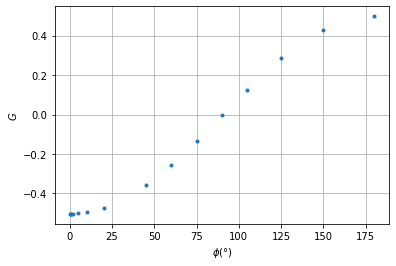

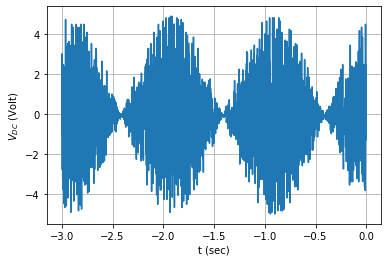

In [4]:
display(ampinvgainavg, ampinvgainerr, ampninvgainavg, ampninvgainerr, daoutavg, (beatwavg/(2*math.pi))**-1)
fig1 = plt.figure()
plt.xlabel('$\phi (°)$')
plt.ylabel('$G$')
plt.grid()
plt.plot(phdeg[:], daoutavg[:], '.')
plt.show()

#file_name = f'data/batt_1.csv'
df1 = pd.read_csv(file_name, skiprows=[0]).dropna()
peaks, peak_prop = signal.find_peaks(df1['Volt'], prominence=3)

fig2 = plt.figure()
plt.grid()
plt.plot(df1['second'], df1['Volt'], '-')
plt.xlabel('t (sec)')
plt.ylabel('$V_{DC}$ (Volt)')
plt.show()

57108.19 +- 6065
82889.98 +- 6064
79590.60 +- 6078
73195.26 +- 6062
69249.19 +- 6066


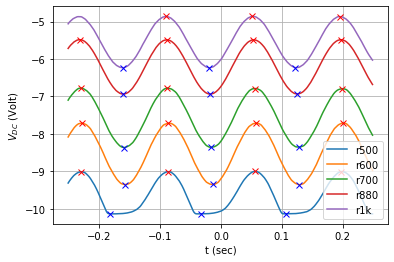

69249.19055000001

0.00012

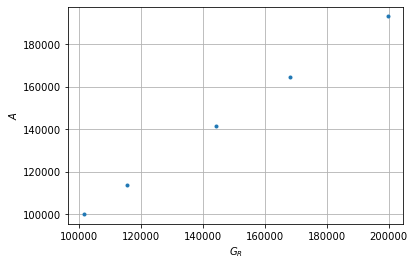

In [7]:
# Parte 1
R100k = 98.835e3; # Ohm
R10k = 9.9696e3; # Ohm

R100k1 = 98.835e3; # Ohm messo nel -
R10k1 = 9.9696e3; # Ohm messo nel -
R100k2 = 99.454e3; # Ohm Fascia nera, messo nel +
R10k2 = 9.8652e3; # Ohm Fascia nera, messo nel +

R100a = 0.10213e3 # usata nel circuito

R = [0.50550e3, 0.60252e3, 0.70333e3, 0.88174e3, 1.0059e3]

filebase = ['r500', 'r600', 'r700', 'r880', 'r1k']
gainol = []
gainolarr = []
fig3 = plt.figure()
plt.grid()
for i in filebase:
    for j in range(0,1):
        settings_file = f'data/{i}_{j}.txt'
        with open(settings_file, 'r') as f:
            scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
            delta_V = 8*scale_V*3e-2
        file_name = f'data/{i}_{j}.csv'
        df = pd.read_csv(file_name, skiprows=[0]).dropna()
        #df['Volt'] = df['Volt'] - df['Volt'][1]
        pk1, pkp1 = signal.find_peaks(df['Volt'], prominence=.2)
        pk2, pkp2 = signal.find_peaks(-df['Volt'], prominence=.2)
        plt.plot(df['second'], df['Volt'], label=i)
        plt.plot(df['second'][pk1], df['Volt'][pk1], 'xr')
        plt.plot(df['second'][pk2], df['Volt'][pk2], 'xb')
        #popt5, pcov5 = curve_fit(sinf, df['second'], df['Volt'], p0=[0.75, 2*math.pi*0.1, -0.018])
        #gainol = (df['Volt'].max() - df['Volt'].min())/(0.9e-3*101**(-1))
        gainol = (df['Volt'][pk1].mean() - df['Volt'][pk2].mean())/(2e-3*101**(-1))
        dgainol = np.sqrt((df['Volt'][pk1].std())**2 + (df['Volt'][pk2].std())**2 + delta_V**2)/(2e-3*101**(-1))
        
        print('%.2f +- %0.f' % (gainol, dgainol))
plt.xlabel('t (sec)')
plt.ylabel('$V_{DC}$ (Volt)')
plt.legend()
plt.show()

gainolarr = [56542.77, 82069.28, 78802.58, 72470.56, 68563.56]
rf = 2*100e3 + (100e3)**2/np.asarray(R)
Gr = rf/100
#A = np.asarray(gainolarr) / (rf/(rf+100) + np.asarray(gainolarr)*100/(rf+100))
A = 100*(rf+100)/(1/np.asarray(gainolarr)*rf+100*100)
display(gainol)
fig4 = plt.figure()
plt.xlabel('$G_R$')
plt.ylabel('$A$')
plt.grid()
plt.plot(Gr, A, '.')
fig4.savefig('fig4.pdf', bbox_inches='tight')
display(12/100000)

In [6]:
fig1.savefig('fig1.pdf', bbox_inches='tight')
fig2.savefig('fig2.pdf', bbox_inches='tight')
fig3.savefig('fig3.pdf', bbox_inches='tight')